# The Log-Periodic Power Law Model for Stock Market Crash

## Exploratory Data Analysis of First Republic Bank (ticker: FRC) Stock Price 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [2]:
df = pd.read_csv('frc.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


print(min(df.index), max(df.index))
display(df.describe())

2010-12-09 00:00:00 2023-04-10 00:00:00


,Open,High,Low,Close,Adj Close,Volume
count,3103.000000,3103.000000,3103.000000,3103.000000,3103.000000,3.103000e+03
mean,85.789330,86.749552,84.809007,85.793603,83.212934,1.589602e+06
std,47.680324,48.218400,47.092009,47.636768,48.034025,8.954700e+06
min,11.980000,13.010000,11.520000,12.180000,12.180000,2.830000e+04
25%,48.090000,48.555000,47.449999,47.879999,44.913662,5.649500e+05
50%,85.599998,87.519997,83.680000,85.349998,82.856384,8.100000e+05
75%,106.145001,107.329998,105.000000,106.215000,103.782921,1.157700e+06
max,221.460007,222.860001,218.600006,221.910004,219.898956,2.284998e+08


### Pirce and volume evolution

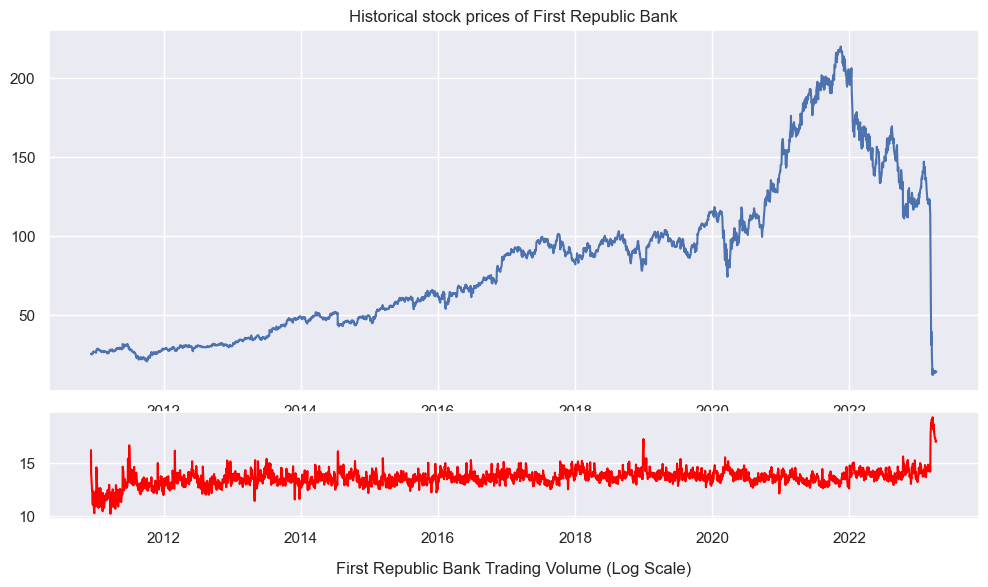

In [3]:
# price and volume evolution

top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(df.index, df["Adj Close"])
plt.title('Historical stock prices of First Republic Bank')

bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.plot(df.index, np.log(df['Volume']), color='red')
plt.title('\nFirst Republic Bank Trading Volume (Log Scale)', y=-0.60)

plt.gcf().set_size_inches(12,8)

### Using moving average to identify regimes

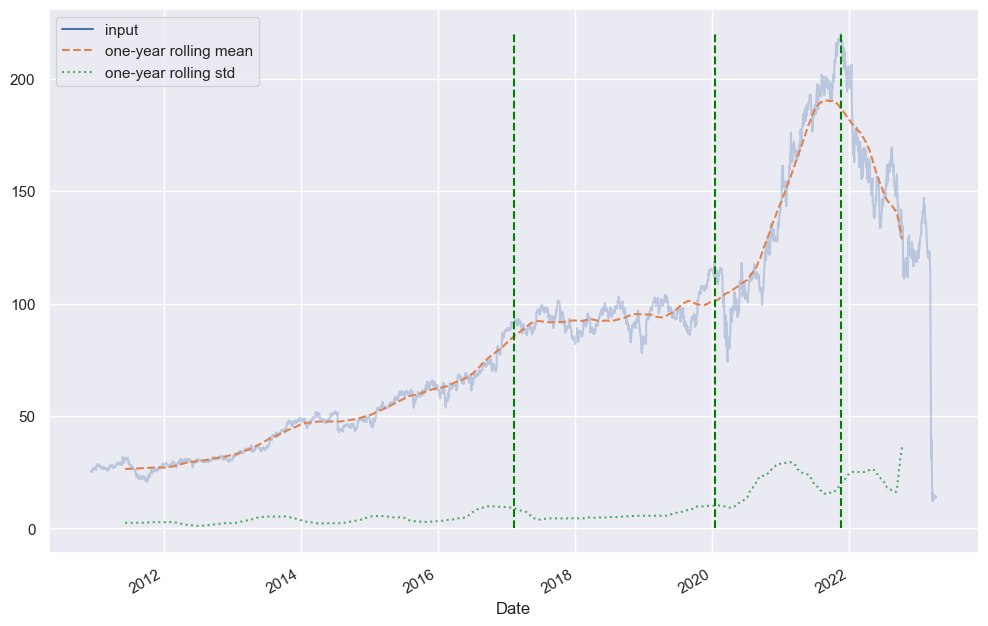

In [4]:
# regime changes in stock price evolution
rolling = df['Adj Close'].rolling(window=250, center=True)
data = pd.DataFrame({'input': df['Adj Close'], 'one-year rolling mean': rolling.mean(), 'one-year rolling std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])

plt.vlines(x=[pd.to_datetime('2/8/2017'), pd.to_datetime('1/14/2020'), pd.to_datetime('11/16/2021')], ymin=0, ymax=df['Adj Close'].max(), linestyles='dashed', colors='green')

ax.lines[0].set_alpha(0.3)

plt.gcf().set_size_inches(12,8)

## Multi-Resolution Detection of Mean Shifts

**TODO**

- Fractional Gaussian process to model log return series
- Multi-resolution analysis and anomaly detection for log price returns

##  The Log-Periodic Power Law Model

- Anders Johansen, Olivier Ledoit, and Didier Sornette. “Crashes as critical points”. International Journal of Theoretical and Applied Finance, Vol. 3, No. 2 (2000) 219-255.
- K. Bastiaensen, P. Cauwels, D. Sornette, R. Woodard, and W.-X. Zhou. “The Chinese equity bubble: Ready to burst”. arxiv:0907.1827, July 10, 2009.
- Didier Sornette, Ryan Woodard and Wei-Xing Zhou. “The 2006-2008 oil bubble: Evidence of speculation, and prediction”. Physica A 388 (2009) 1571-1576.

In [5]:
# python standard library: https://docs.python.org/3/library/
import json
import os
import traceback

# third party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import seaborn; seaborn.set()
import statsmodels.api as sm

class LPPLModel:
    """Log-Period Power Law (LPPL) to model market bubble and crash."""

    def __init__(self, data_path: str) -> None:
        """
        Args:
            data_path (str): file path to the data file of daily price.
        """
        if data_path is None:
            raise ValueError('ERROR: input argument data_path is None')
        if not isinstance(data_path, str):
            raise TypeError('ERROR: input argument data_path is not of type str')

        if not os.path.exists(data_path):
            raise ValueError(f'ERROR: data file {data_path} does not exist')

        self._data = None
        self._ticker = data_path.split('\\')[-1].replace('.csv', '').upper()
        self._A = None
        self._A_range = (0.0, np.PINF)
        self._B = None
        self._B_range = (np.NINF, 0.0)
        self._C = None
        self._C_range = (-1.0, 1.0)
        self._beta = None
        self._beta_range = [0.1, 0.9]
        self._omega = None
        self._omega_range = [6.0, 15.0]
        self._phi = None
        self._phi_range = [0, 2 * np.pi]
        self._tc_delta = None         # unit: day
        self._tc_delta_range = None   # typically 10% of the calibration window

        df = pd.read_csv(data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        df['log_px'] = np.log(df['Adj Close'])
        self._data = df.set_index('Date')

        print(f'--- loaded data from {data_path} for [{min(self._data.index)}, {max(self._data.index)}], data size {self._data.shape}')

    def _calc_init_candidates(self, start_dt: pd.Timestamp, end_dt: pd.Timestamp) -> pd.DataFrame:
        """Use grid search to identify initial guesses of the model parameters.
        Args:
            start_dt (pandas.Timestamp): start date of the calibration window.
            end_dt (pandas.Timestamp): end date of the calibration window.
            peak_dt (pandas.Timestamp): the actual date when asset price peaked.
        """

        df = self._data[(self._data.index >= start_dt) & (self._data.index <= end_dt)]

        self._tc_delta_range = [1.0, 0.1 * df.shape[0]]

        candidates = list()

        # grid search:
        step_size_beta = 0.1
        step_size_omega = 1.0
        step_size_phi = 0.1
        step_size_tc_delta = 1.0
        for beta in np.arange(self._beta_range[0], self._beta_range[1] + step_size_beta, step_size_beta):
            print(f'beta: {beta}')
            for omega in np.arange(self._omega_range[0], self._omega_range[1] + step_size_omega, step_size_omega):
                for phi in np.arange(self._phi_range[0], self._phi_range[1] + step_size_phi, step_size_phi):
                    for tc_delta in np.arange(self._tc_delta_range[0], self._tc_delta_range[1] + step_size_tc_delta):
                        output = self._optimize_linear_params(data=df,
                                                              beta=beta,
                                                              omega=omega,
                                                              phi=phi,
                                                              tc_delta=tc_delta)
                        A = output.get('A')
                        B = output.get('B')
                        C = output.get('C')
                        mse_resid = output.get('mse_resid')

                        num_oscillations = omega / (2 * np.pi) * np.log((tc_delta + df.shape[0]) / tc_delta)
                        damping_factor = beta * np.abs(B) / (omega * np.abs(C))

                        model_px = np.exp(self._model_log_px_in_calib_period(df, A, B, C, beta, omega, phi, tc_delta))
                        rel_err = (model_px - df['Adj Close']) / df['Adj Close']
                        min_rel_err = rel_err.min()
                        max_rel_err = rel_err.max()

                        # if (A > 0) and (B < 0) and (-1 < C < 1) and (num_oscillations >= 2.5) and (damping_factor >= 1) and (min_rel_err > -0.2) and (max_rel_err < 0.2):
                        if (A > 0) and (B < 0) and (-1 < C < 1) and (num_oscillations >= 2.5) and (damping_factor >= 1):
                            params = pd.DataFrame({'A': [A],
                                                   'B': [B],
                                                   'C': [C],
                                                   'beta': [beta],
                                                   'omega': [omega],
                                                   'phi': [phi],
                                                   'tc_delta': [tc_delta],
                                                   'mse_resid': [mse_resid],
                                                   'oscillations': [num_oscillations],
                                                   'damping_factor': [damping_factor],
                                                   'min_rel_err': [min_rel_err],
                                                   'max_rel_err': [max_rel_err]
                                                   })
                            # print(params)
                            candidates.append(params)

        candidates = pd.concat(candidates).reset_index()
        candidates.to_csv(f'{self._ticker}_{start_dt.strftime("%Y%m%d")}_{end_dt.strftime("%Y%m%d")}_candidates.csv', index=False)

        return candidates

    def _model_log_px_in_calib_period(self, data: pd.DataFrame, A: float, B: float, C: float, beta: float, omega: float, phi: float, delta_t: float) -> np.ndarray:
        """Compute model log price during the calibration period (data must be the calibration data)."""

        # convert number of days to year fraction
        delta_t = (delta_t + data.shape[0] - 1 - np.array(range(data.shape[0]))) / 250

        x1 = np.power(delta_t, beta)
        x2 = np.array([x * np.cos(omega * np.log(t) + phi) if t > 0 else 0.0 for x, t in zip(x1, delta_t)])

        return A + B * x1 + C * x2

    def _obj_fun(self, x: np.ndarray, params: dict) -> float:
        """ Objective function sending to optimizer. x = [beta, omega, phhi, tc_delta].
        Args:
            x (numpy.ndarray): a numpy array of size 4.
            params (dict): {'data': pandas.DataFrame}.
        """
        data = params['data']
        linear_params = self._optimize_linear_params(data=data, beta=x[0], omega=x[1], phi=x[2], tc_delta=x[3])
        return linear_params['ssr']

    def _optimize_linear_params(self, data: pd.DataFrame, beta: float, omega: float, phi: float, tc_delta: float) -> dict:
        """ Given beta, omega, phi, tc_delta, calculate parameters A, B, C by OLS. """
        # convert number of days to year fraction
        delta_t = (tc_delta + data.shape[0] - 1 - np.arange(data.shape[0]))/250.0

        x1 = np.power(delta_t, beta)
        x2 = x1 * np.cos(omega * np.log(delta_t) + phi)

        X = np.column_stack((x1, x2))
        X = sm.add_constant(X)

        y = np.array(data['log_px'])

        reg_model = sm.OLS(y, X)
        reg_results = reg_model.fit()
        A, B, C = reg_results.params

        return {'A': A, 'B': B, 'C': C, 'ssr': reg_results.ssr, 'mse_resid': reg_results.mse_resid}

    def _optimize_all_params(self, data: pd.DataFrame, init_beta: float, init_omega: float, init_phi: float, init_tc_delta: float) -> dict:
        """ Find the optimal beta, omega, phi, tc_delta. Parameters A, B, C are calculated as functions of these 4 parameters. """
        # TODO: implement optimization routines - Levenberg-Marquardt, genetic algorithm.

        # beta = init_beta
        # omega = init_omega
        # phi = init_phi
        # tc_delta = init_tc_delta

        # Nelder-Mead downhill simplex minimization
        x0 = np.array([init_beta, init_omega, init_phi, init_tc_delta])
        params = {'data': data}
        bounds = ((self._beta_range[0], self._beta_range[1]),
                  (self._omega_range[0], self._omega_range[1]),
                  (self._phi_range[0], self._phi_range[1]),
                  (1.0, 0.1*data.shape[0]))
        res = minimize(fun=self._obj_fun,
                       x0=x0,
                       args=params,
                       method='Nelder-Mead',
                       bounds=bounds,
                       tol=1e-10,
                       options={'maxiter': 500, 'disp': False})
        beta, omega, phi, tc_delta = res.x

        # compute the linear parameters by optimal nonlinear parameters
        linear_params =self._optimize_linear_params(data=data, beta=beta, omega=omega, phi=phi, tc_delta=tc_delta)

        # diagnostics
        num_oscillations = omega / (2 * np.pi) * np.log((tc_delta + data.shape[0]) / tc_delta)
        damping_factor = beta * np.abs(linear_params['B']) / (omega * np.abs(linear_params['C']))

        return {'A': linear_params['A'],
                'B': linear_params['B'],
                'C': linear_params['C'],
                'beta': beta,
                'omega': omega,
                'phi': phi,
                'tc_delta': tc_delta,
                'oscillations': num_oscillations,
                'damping_factor': damping_factor,
                'mse_resid': linear_params['mse_resid']}

    def calc_model_px(self, data: pd.DataFrame, A: float, B: float, C: float, beta: float, omega: float, phi: float, tc: pd.Timestamp) -> np.ndarray:
        """ Assuming model parameters are given, calculate the forecasted trajectory of asset price. """
        cutoff_dt = min(tc, data.index[-1])
        df = data[data.index <= cutoff_dt]

        if tc == cutoff_dt:
            delta_t = (df.shape[0] - 1 - np.array(range(df.shape[0]))) / 250
        else:
            delta_t = (self._tc_delta + df.shape[0] - 1 - np.array(range(df.shape[0]))) / 250

        x1 = np.power(delta_t, beta)
        x2 = np.array([x * np.cos(omega * np.log(t) + phi) if t > 0 else 0.0 for x, t in zip(x1, delta_t)])

        return pd.Series(data=np.exp(A + B * x1 + C * x2), index=df.index)

    def fit(self, start_dt: pd.Timestamp, end_dt: pd.Timestamp) -> None:
        """ Model calibration.
        Args:
            start_dt (pandas.Timestamp): start date of the calibration window.
            end_dt (pandas.Timestamp): end date of the calibration window.
            peak_dt (pandas.Timestamp): the actual date when asset price peaked.
        """
        print(f'\t--- fitting model on data from {start_dt} to {end_dt}')

        init_guess_file = f'{self._ticker}_{start_dt.strftime("%Y%m%d")}_{end_dt.strftime("%Y%m%d")}_candidates.csv'
        if os.path.exists(init_guess_file):
            print(f'\t\tLoading initial guesses of model parameters from {init_guess_file}...')
            candidates = pd.read_csv(init_guess_file)
        else:
            print(f'\t\tComputing initial guesses of model parameters and saving them to {init_guess_file}...')
            candidates = self._calc_init_candidates(start_dt, end_dt)

        # choose the first 10 candidates of parameters by mse_resid
        candidates = candidates.sort_values(by='mse_resid').reset_index().head(n=10)

        # optimize
        opt_result_list = list()
        mse_resid_list = list()
        df = self._data[(self._data.index>=start_dt) & (self._data.index<=end_dt)]
        for i in range(candidates.shape[0]):
            init_beta = candidates.loc[i, 'beta']
            init_omega = candidates.loc[i, 'omega']
            init_phi = candidates.loc[i, 'phi']
            init_tc_delta = candidates.loc[i, 'tc_delta']
            opt_result = self._optimize_all_params(data=df,
                                                   init_beta=init_beta,
                                                   init_omega=init_omega,
                                                   init_phi=init_phi,
                                                   init_tc_delta=init_tc_delta)
            opt_result_list.append(opt_result)
            mse_resid_list.append(opt_result['mse_resid'])

        opt_params = opt_result_list[mse_resid_list.index(min(mse_resid_list))]

        self._A = opt_params['A']
        self._B = opt_params['B']
        self._C = opt_params['C']
        self._beta = opt_params['beta']
        self._omega = opt_params['omega']
        self._phi = opt_params['phi']
        self._tc_delta = np.ceil(opt_params['tc_delta'])

        model_params = {'A': self._A,
                        'B': self._B,
                        'C': self._C,
                        'beta': self._beta,
                        'omega': self._omega,
                        'phi': self._phi,
                        'tc_delta': self._tc_delta,
                        'oscillations': opt_params['oscillations'],
                        'damping_factor': opt_params['damping_factor'],
                        'mse_resid': opt_params['mse_resid']
                        }

        with open(f'{self._ticker}_{start_dt.strftime("%Y%m%d")}_{end_dt.strftime("%Y%m%d")}_params.json', "w") as outfile:
            json.dump(model_params, outfile)

    def predict(self, start_dt: pd.Timestamp, end_dt: pd.Timestamp, peak_dt: pd.Timestamp) -> None:
        """ Plot actual and forecasted price trajectories; also do calibration if model parameters (in json) are unavailable.
        Args:
            start_dt (pandas.Timestamp): start date of the calibration window.
            end_dt (pandas.Timestamp): end date of the calibration window.
            peak_dt (pandas.Timestamp): the actual date when asset price peaked.
        """
        print(f'--- predicting based on calibration window [{start_dt}, {end_dt}]')

        model_params_file = f'{self._ticker}_{start_dt.strftime("%Y%m%d")}_{end_dt.strftime("%Y%m%d")}_params.json'

        if not os.path.exists(model_params_file):
            print(f'\tmodel parameters unavailable for the calibration period [{start_dt}, {end_dt}]; calibrating...')
            model.fit(start_dt=start_dt, end_dt=end_dt)
        else:
            print(f'\tloading model parameters from {model_params_file}...')
            with open(model_params_file) as f:
                model_params = json.load(f)
            self._A = model_params['A']
            self._B = model_params['B']
            self._C = model_params['C']
            self._beta = model_params['beta']
            self._omega = model_params['omega']
            self._phi = model_params['phi']
            self._tc_delta = model_params['tc_delta']

        df = self._data.copy()

        # for FRC and TSLA, only take the data after 1/1/2018 since the data are interesting only after that date
        if self._ticker == 'FRC':
            df = df[df.index >= min([start_dt, pd.to_datetime('1/1/2018')])]
        if self._ticker == 'TSLA':
            df = df[df.index >= min([start_dt, pd.to_datetime('1/1/2018')])]

        tc = end_dt + pd.tseries.offsets.BDay(self._tc_delta)
        df['model_px'] = self.calc_model_px(data=df, A=self._A, B=self._B, C=self._C, beta=self._beta,
                                                omega=self._omega, phi=self._phi, tc=tc)

        crash_px = np.exp(self._A)

        plt.figure(figsize=(16,12))
        ax = df[['Adj Close', 'model_px']].plot(style=['-', ':'])
        plt.vlines(x=[start_dt, end_dt, peak_dt, tc],
                   ymin=0,
                   ymax=df['Adj Close'].max(),
                   linestyles=['dashed', 'dashed', 'solid', 'dashed'],
                   colors=['green', 'green', 'red', 'blue'])
        ax.lines[0].set_alpha(0.3)
        ax.set_title(f'{self._ticker} calibration period: [{start_dt.strftime("%Y-%m-%d")}, {end_dt.strftime("%Y-%m-%d")}]\n'
                     f'model peak: {tc.strftime("%Y-%m-%d")}@{round(crash_px,2)} ({self._tc_delta} bds from calibration end)\n'
                     f'actual peak: {peak_dt.strftime("%Y-%m-%d")}@{round(self._data.loc[peak_dt, "Adj Close"],2)}')

        # fig = plt.gcf()
        # fig.set_size_inches(12, 9)
        plt.savefig(f'{self._ticker}_{start_dt.strftime("%Y%m%d")}_{end_dt.strftime("%Y%m%d")}.png', dpi=100)


### Case study: First Republic Bank (FRC)

--- loaded data from frc.csv for [2010-12-09 00:00:00, 2023-04-10 00:00:00], data size (3103, 7)
--- predicting based on calibration window [2020-03-23 00:00:00, 2021-10-13 00:00:00]
	loading model parameters from FRC_20200323_20211013_params.json...


<Figure size 1600x1200 with 0 Axes>

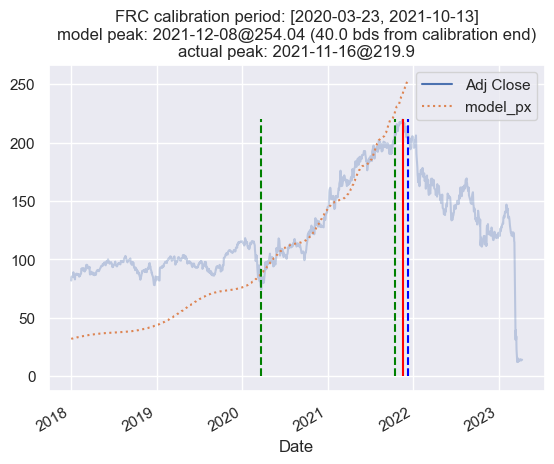

In [6]:
model = LPPLModel(data_path='frc.csv')

model.predict(start_dt=pd.to_datetime('3/23/2020'), end_dt=pd.to_datetime('10/13/2021'), peak_dt=pd.to_datetime('11/16/2021'))

### Case study: Tesla (TSLA)

--- loaded data from tsla.csv for [2010-06-29 00:00:00, 2023-05-19 00:00:00], data size (3246, 7)
--- predicting based on calibration window [2019-12-09 00:00:00, 2020-12-21 00:00:00]
	loading model parameters from TSLA_20191209_20201221_params.json...


<Figure size 1600x1200 with 0 Axes>

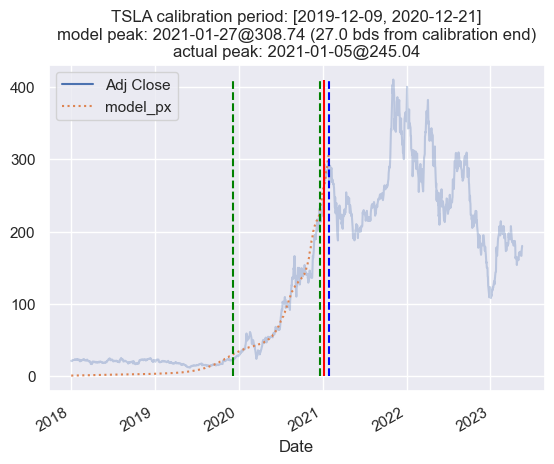

In [7]:
model = LPPLModel(data_path='tsla.csv')

model.predict(start_dt=pd.to_datetime('12/9/2019'), end_dt=pd.to_datetime('12/21/2020'), peak_dt=pd.to_datetime('1/5/2021'))

--- predicting based on calibration window [2021-05-17 00:00:00, 2021-10-04 00:00:00]
	loading model parameters from TSLA_20210517_20211004_params.json...


<Figure size 1600x1200 with 0 Axes>

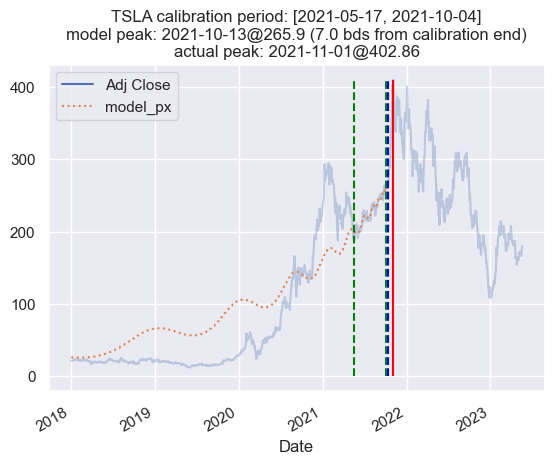

In [8]:
model.predict(start_dt=pd.to_datetime('5/17/2021'), end_dt=pd.to_datetime('10/4/2021'), peak_dt=pd.to_datetime('11/1/2021'))

### Case study: GameStop (GME)

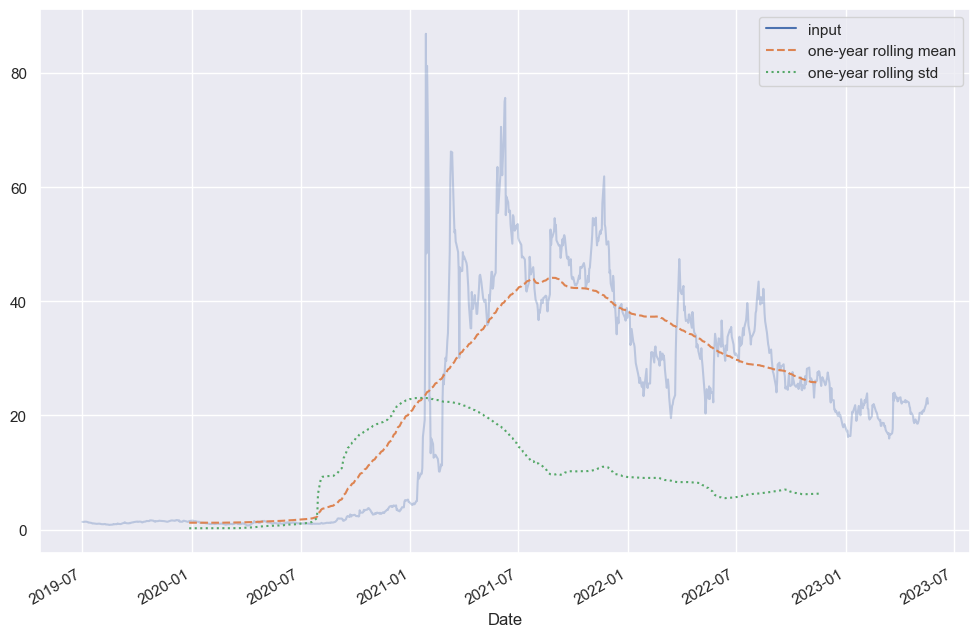

In [9]:
df = pd.read_csv('gme.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[df.index >= pd.to_datetime('7/1/2019')]

# regime changes in stock price evolution
rolling = df['Adj Close'].rolling(window=250, center=True)
data = pd.DataFrame({'input': df['Adj Close'], 'one-year rolling mean': rolling.mean(), 'one-year rolling std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])

ax.lines[0].set_alpha(0.3)

plt.gcf().set_size_inches(12,8)

--- loaded data from gme.csv for [2002-02-13 00:00:00, 2023-05-19 00:00:00], data size (5354, 7)
--- predicting based on calibration window [2020-07-05 00:00:00, 2021-01-26 00:00:00]
	loading model parameters from GME_20200705_20210126_params.json...


<Figure size 1600x1200 with 0 Axes>

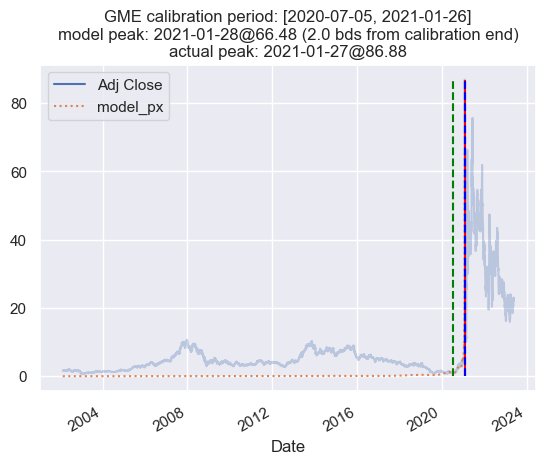

In [10]:
model = LPPLModel(data_path='gme.csv')

model.predict(start_dt=pd.to_datetime('7/5/2020'), end_dt=pd.to_datetime('1/26/2021'), peak_dt=pd.to_datetime('1/27/2021'))